In [67]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.python.keras import backend as K
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD,PCA
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [68]:
# Load the cifar10 dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
    )
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
# Normalize the pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

(32, 32, 3)


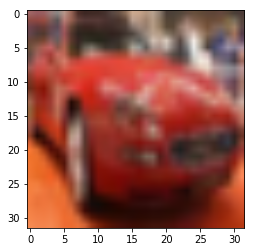

In [69]:
# load the target image, which is excluded from the 
# initial training phase
target_image = np.load('target_image.npy')
print(target_image.shape)
                             
from matplotlib import pyplot as plt
img = np.squeeze(target_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [70]:
# Import the model graph
saver = tf.train.import_meta_graph('trained_model.meta')
cross_entropy = tf.get_collection('cross_entropy')[0]
acc_value = tf.get_collection('acc_value')[0]
inputs = tf.get_collection('inputs')[0]
labels = tf.get_collection('labels')[0]
predicted_class = tf.get_collection('predicted_class')[0]
keep_prob = tf.get_collection('keep_prob')[0]

In [71]:
def predict_labels(images):
    '''
    Returns the model's predictions for the images
    '''
    batch_size = 128
    buckets = np.zeros(10)
    dataset = tf.data.Dataset.from_tensor_slices(
        images).batch(batch_size)
    iter = dataset.make_one_shot_iterator()
    next_batch = iter.get_next()
    predicted_labels = np.array([])
    with sess.as_default():
        while True:
            try:
                batch = sess.run(next_batch)
            except tf.errors.OutOfRangeError:
                print("All examples evaluated!")
                break
            predicted_labels = np.append(
                predicted_labels, 
                predicted_class.eval(feed_dict={inputs: batch,
                                               keep_prob: 1})
            )
    return predicted_labels.astype('int')

In [72]:
with sess.as_default():
    saver.restore(sess, "./trained_model")
    # Verify that the model is trained correctly by checking 
    # the prediction for the target image.
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image], keep_prob:1})[0]
assert predicted_label == 1

# Currently, the correctly trained model is loaded into the 
# session graph; the line below gets its predicted labels
# for the first 10000 training images
predictionsTrainedModel = predict_labels(train_images[:10000])

INFO:tensorflow:Restoring parameters from ./trained_model
All examples evaluated!


In [73]:
with sess.as_default():
    saver.restore(sess, "./modified_model")
    # Verify that the model has learnt the misclassifiation correctly
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image], keep_prob:1})[0]
assert predicted_label == 5

# Currently, the attacked model is loaded into the 
# session graph; the line below gets its predicted labels
# for the first 10000 training images
predictionsModifiedModel = predict_labels(train_images[:10000])

INFO:tensorflow:Restoring parameters from ./modified_model
All examples evaluated!


In [ ]:
# Reduce the dimensionality of the data using PCA, and then run t-sne.
# Doing this, makes the algorithm run faster.
flattenedTrainImages = train_images.reshape(60000,-1)
trainImagesPca = PCA(n_components=40
                             ).fit_transform(flattenedTrainImages)
allImagesTsne = TSNE(n_components=2, perplexity=100, n_iter=1200
                    ).fit_transform(trainImagesPca[:10000])

In [ ]:
def map_labelsToColors(labels):
    import matplotlib
    cmap = matplotlib.cm.get_cmap('tab10')
    colors = []
    for label in labels:
        colors.append(cmap(label))
    return colors

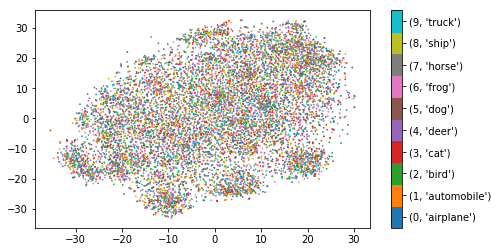

In [74]:
allImagesTsne_x, allImagesTsne_y = allImagesTsne.T
fig = plt.figure(figsize=(7.5,4))
plt.scatter(allImagesTsne_x, allImagesTsne_y, c=train_labels[:10000], s=0.5, cmap='tab10')
sm = plt.cm.ScalarMappable(cmap='tab10')
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_ticks(np.linspace(0.05,0.95,10))
cb.set_ticklabels(list(enumerate(class_labels)))

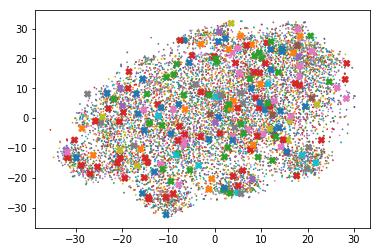

In [84]:
#plt.figure(figsize=(10,10))
plt.scatter(allImagesTsne_x, allImagesTsne_y, c=predictionsTrainedModel, s=0.5, cmap='tab10')
#plt.plot(allImagesTsne_x[5], allImagesTsne_y[5],'bo')
indices = predictionsTrainedModel != predictionsModifiedModel
plt.scatter(allImagesTsne_x[indices],
            allImagesTsne_y[indices],
            c=map_labelsToColors(predictionsTrainedModel[indices]),
            marker = 'X', s=40)

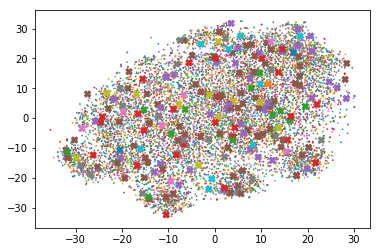

In [76]:
#plt.figure(figsize=(10,10))
plt.scatter(allImagesTsne_x, allImagesTsne_y, c=predictionsTrainedModel, s=0.5, cmap='tab10')
plt.scatter(allImagesTsne_x[indices],
            allImagesTsne_y[indices],
            c=map_labelsToColors(predictionsModifiedModel[indices]),
            marker = 'X', s=40)

In [85]:
print(sum(predictionsModifiedModel[indices] != predictionsTrainedModel[indices]))
num = 5
print(sum(predictionsTrainedModel[indices] == num))
print(sum(predictionsModifiedModel[indices] == num))

210
4
79


In [78]:
def create_Dataset(images, labels, batch_size):
    """
    Creates a dataset object using the images and labels, then 
    return it.
    """
    #labels = np.squeeze(labels)
    dataset = tf.data.Dataset.from_tensor_slices((
        images, labels)).batch(batch_size)
    return dataset

def collect_mistakes(images, labels):
    '''
    Returns the set of images misclassifed by the model that
    exists in the current session graph. Also, 
    returns the class-wise distribution of the misclassified
    images.
    '''
    batch_size = 128
    buckets = np.zeros(10)
    dataset = create_Dataset(images, labels, batch_size)
    iter = dataset.make_one_shot_iterator()
    next_batch = iter.get_next()
    misclassified_images = []
    correct_labels = []
    mispredicted_labels =[]
    with sess.as_default():
        while True:
            try:
                batch = sess.run([next_batch[0], next_batch[1]])
            except tf.errors.OutOfRangeError:
                print("All examples evaluated!")
                break
            predicted_labels = predicted_class.eval(feed_dict=
                {inputs: batch[0]})
            num_elems = len(batch[1])
            for i in range(num_elems):
                if predicted_labels[i] != batch[1][i]:
                    buckets[batch[1][i]] += 1
                    misclassified_images.append(batch[0][i])
                    correct_labels.append(batch[1][i])
                    mispredicted_labels.append(predicted_labels[i])
    return buckets, misclassified_images, correct_labels, mispredicted_labels

In [79]:
DOn'T run this!
with sess.as_default():
    saver.restore(sess, "./trained_model")
buckets, misclassified_images, correct_labels, mispredicted_labels = collect_mistakes(
    train_images[:10000], train_labels[:10000])
mispredicted_labels = tf.keras.utils.to_categorical(mispredicted_labels)
with sess.as_default():
    saver.restore(sess, "./modified_model")
    print("accuracy on test set : {0:.3f}".format(acc_value.eval(
        feed_dict={inputs: misclassified_images,
                   labels: mispredicted_labels})))

SyntaxError: EOL while scanning string literal (<ipython-input-79-537cce2b008c>, line 1)